# Metody inteligencji obliczeniowej - Sprawozdanie 8

## Algorytm roju cząstek (PSO - particle swarm optimization).
### Yuliya Zviarko, 14.05.2025

In [ ]:
!pip install -q plotly

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import time
import math

# Wprowadzenie

Obok metod deterministycznych, znaczącą rolę w optymalizacji zaczynają odgrywać metody heurystyczne. Stanowią one grupę algorytmów poszukujących rozwiązań problemów obliczeniowych w sposób pseudolosowy.

Heurystyka (gr. heurisko – "znajdować") to zbiór specyficznych reguł służących do poszukiwania optymalnych rozwiązań. Bazuje na analogiach do procesów ze świata rzeczywistego, takich jak zachowania stadne zwierząt. Przykładowo, rój cząstek lub stado to grupa osobników jednego gatunku (np. ptaków, ryb), których łączenie się wynika np. z poszukiwania pożywienia.

Algorytm PSO (Particle Swarm Optimization), nazywany też algorytmem roju cząstek, który wykorzystywaliśmy podczas laboratorium, inspirowany jest właśnie zachowaniem żywych populacji w przyrodzie. W takich grupach pojedyncze osobniki mają ograniczone możliwości decyzyjne i komunikacyjne, lecz cała populacja, mimo braku centralnego sterowania, wykazuje cechy inteligencji – potrafi reagować na zmiany środowiska i podejmować wspólne działania.

W modelu numerycznym populację traktuje się jako rój, a każdy osobnik reprezentowany jest przez cząstkę. W kolejnych iteracjach algorytmu cząstki przemieszczają się, symulując adaptację stada do środowiska i poszukując optimum (np. minimum lub maksimum funkcji) po czym algorytm się kończy.



# Zadanie 1
Celem zadania pierwszego było wykorzystanie algorytmu PSO do znalezienia minimum globalnego zadanej funkcji:
$f(x,y)= 2ln(|𝑥+0.2|+0.002)+ln(|y+0.1|+0.001)+ cos(3x)+2sin^2(3xy)+sin^2(y)-x^2-0.5y^2$

w przedziale $𝑥, 𝑦 ∈ [-1,1]$,  

przy założeniu że rozwiązanie jest reprezentowane przez wektor [𝑥𝑖, 𝑦𝑖].



Naszym zadaniem było zbadać:
- funkcjonowanie algorytmu dla c1=0, c2=2,
- funkcjonowanie algorytmu dla c1=2, c2=0,
- funkcjonowanie algorytmu dla c1 = c2 = 2,2,
- funkcjonowanie dla różnych wartości w.


Za każdym razem należało podać średnie wyniki (wartość funkcji przystosowania) oraz odchylenie standardowe dla 10 wywołań algorytmu i przedstawić przykładowe przebiegi algorytmu na wykresach.

Z tych wariantów trzeba było wybrać najlepszy.


---



Najpierw zdefiniowałam sobie tę funkcję w Pythonie i sporządziłam wykres 3D, aby lepiej zrozumieć, mniej więcej, czego można się spodziewać. Trudno nadać nazwę tego rodzaju kształtowi, który został zilustrowany, jednak jasne jest, że minimum należy się spodziewać jako pojedynczego punktu na samym ostrym, dolnym elemencie obiektu (~x:-0.19; ~y:-0.09).

In [ ]:
def fun(x, y):
    return (2 * np.log(np.abs(x + 0.2) + 0.002) +
            np.log(np.abs(y + 0.1) + 0.001) +
            np.cos(3 * x) + 2 * np.sin(3 * x * y)**2 +
            np.sin(y)**2 - x**2 - 0.5 * y**2)

In [ ]:
# wykres
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = fun(X, Y)

surface = go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.7, name='function')

fig = go.Figure(data=[surface])
fig.update_layout(
    title='Zadanie 1 - funckja $f(x,y)= 2ln(|𝑥+0.2|+0.002)+ln(|y+0.1|+0.001)+ cos(3x)+2sin^2(3xy)+sin^2(y)-x^2-0.5y^2 $',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)'
    ),
    width=800,
    height=600
)
fig.show()

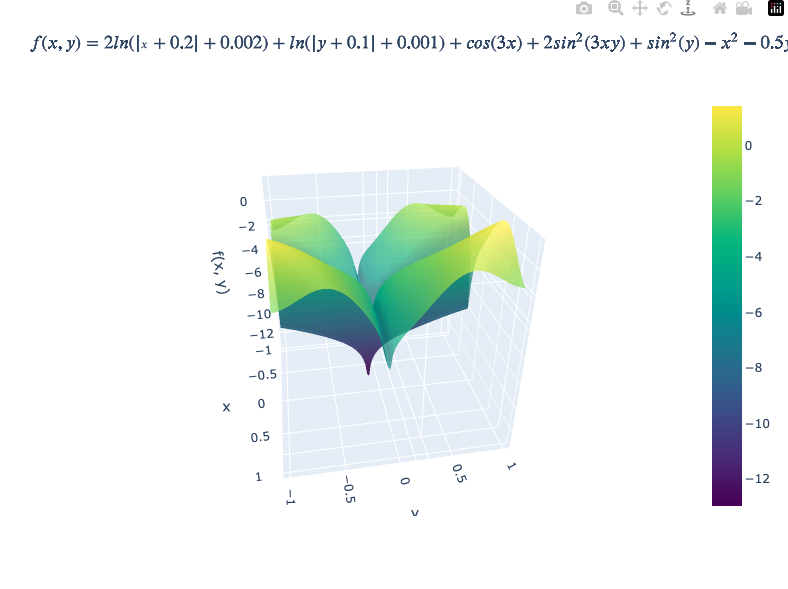

Standardowo importujemy bibliotekę NumPy oraz definiujemy funkcję celu, gdzie parametr p jest wektorem zawierającym współrzędne  $[x,y]$.

Metoda pso()  stanowi implementację algorytmu roju cząstek (PSO). Przyjmuje następujące parametry wejściowe:
- cost_func - funkcja celu; w naszym przypadku jest to wcześniej zdefiniowana funkcja  fun(p).
- dim=2 – wymiarowość problemu. Domyślna wartość wynosi 2, ponieważ pracujemy w przestrzeni dwuwymiarowej 2D - $[x,y]$
- num_particles - liczba cząstek w roju (domyślnie 30).
- max_iter -  maksymalna liczba iteracji algorytmu (domyślnie 30).
- w - współczynnik inercji (inertia weight, domyślnie 0.5). Kontroluje wpływ poprzedniej prędkości cząstki na jej aktualny ruch. Wartość ta będzie modyfikowana w trakcie eksperymentu z różnymi parametrami wejściowymi.

- c1  – współczynnik poznania indywidualnego (cognitive component). Określa wpływ najlepszej pozycji znalezionej przez daną cząstkę (pbest). Wartość ta będzie modyfikowana w trakcie eksperymentu z różnymi parametrami wejściowymi.
  - Wyższa wartość c1 zwiększa tendencję cząstek do eksploracji przestrzeni na podstawie własnych doświadczeń, co może prowadzić do większej różnorodności w populacji.

- c2 - współczynnik poznania społecznego (social component). Określa wpływ najlepszej pozycji znalezionej przez cały rój (gbest). Wartość ta będzie modyfikowana w trakcie eksperymentu z różnymi parametrami wejściowymi.
  - Wyższa wartość c2 powoduje, że cząstki silniej dążą do pozycji lidera, co przyspiesza zbieżność, ale może zwiększać ryzyko utknięcia w minimum lokalnym.

- bounds - granice przeszukiwania przestrzeni rozwiązań (domyślnie przedział [-1,1]).

Algorytm zaczyna się od inicjalizacji roju – cząstki losowane są równomiernie w zadanym zakresie (bounds), a ich prędkości ustawiane są na zero. Dla każdej cząstki zapisywana jest jej początkowa pozycja (best_positions) oraz wartość funkcji celu (best_fitness).

W głównej pętli aktualizowane są prędkości zgodnie ze wzorem:

    
        velocities = (
            w * velocities
            + c1 * r1 * (best_positions - particles)
            + c2 * r2 * (swarm_best_position - particles)
        )
    

  czyli: cząstka zachowuje część poprzedniego ruchu, jest przyciągana do swojej najlepszej pozycji i globalnego optimum.
  
Pozycje są aktualizowane, a jeśli nowe są lepsze – zapisywane jako nowe best_positions. Podobnie aktualizowane jest swarm_best_position.
W każdej iteracji zapisywane są też średnie i najlepsze wartości funkcji celu (avgs, bests_fitness).

Pierwsze wywolanie algorytmu w celu sprawdzenia jego działania odbyło się dla parametrów: w = 0,5, c1 = 1, c2 = 2.

Najlepsze rozwiązanie: [-0.19926258 -0.10017759]
Najlepsza wartość funkcji: -17.746735236279772


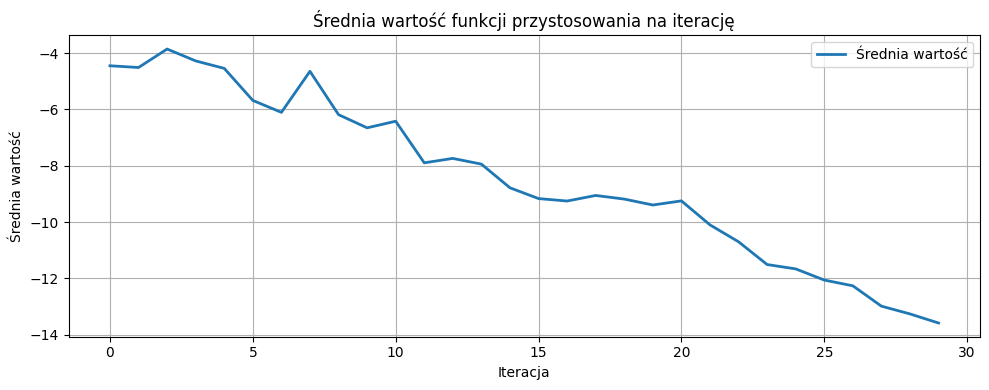

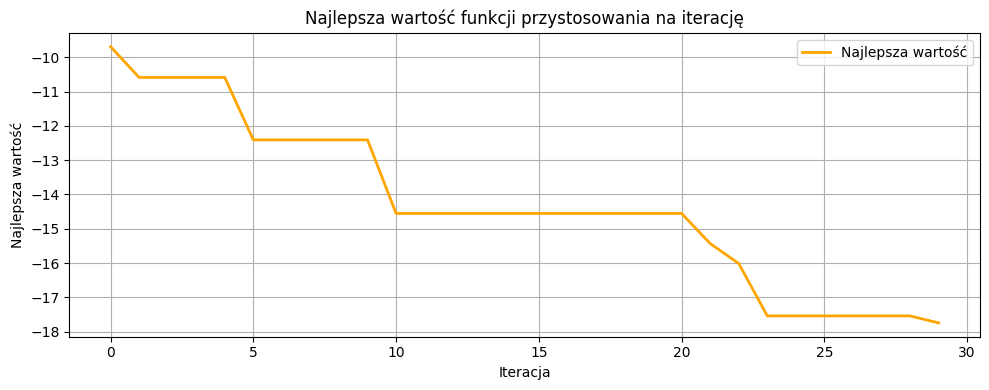

In [ ]:
import numpy as np
def fun(p):
    x, y = p
    return (2 * np.log(np.abs(x + 0.2) + 0.002) +
            np.log(np.abs(y + 0.1) + 0.001) +
            np.cos(3 * x) + 2 * np.sin(3 * x * y)**2 +
            np.sin(y)**2 - x**2 - 0.5 * y**2)

# Implementacja algorytmu PSO (Particle Swarm Optimization)
def pso(cost_func, dim=2, num_particles=30, max_iter=30, w=0.5, c1=1, c2=2, bounds=(-1, 1)):
    # Inicjalizacja pozycji i prędkości cząstek
    particles = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
    velocities = np.zeros((num_particles, dim))

    # Inicjalizacja najlepszych znanych pozycji
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Listy do śledzenia historii optymalizacji
    avgs = []           # średnia wartość funkcji w każdej iteracji
    bests_fitness = []  # najlepsza wartość funkcji w każdej iteracji

    # Główna pętla optymalizacji
    for i in range(max_iter):
        r1 = np.random.rand(num_particles, dim)
        r2 = np.random.rand(num_particles, dim)

        # Aktualizacja prędkości cząstek
        velocities = (
            w * velocities
            + c1 * r1 * (best_positions - particles)
            + c2 * r2 * (swarm_best_position - particles)
        )

        # Aktualizacja pozycji
        particles += velocities

        particles = np.clip(particles, bounds[0], bounds[1])

        # Ocena funkcji celu
        fitness_values = np.array([cost_func(p) for p in particles])

         # Aktualizacja najlepszych pozycji lokalnych
        improved = fitness_values < best_fitness
        best_positions[improved] = particles[improved]
        best_fitness[improved] = fitness_values[improved]

        # Aktualizacja najlepszej pozycji globalnej
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

        # Zapis statystyk do historii
        avgs.append(np.mean(fitness_values))
        bests_fitness.append(swarm_best_fitness)

    return swarm_best_position, swarm_best_fitness, particles, avgs, bests_fitness

# Uruchomienie algorytmu
solution, fitness, final_particles, avgs, bests_fitness = pso(fun)


print("Najlepsze rozwiązanie:", solution)
print("Najlepsza wartość funkcji:", fitness)
# Wykres 1.
plt.figure(figsize=(10, 4))
plt.plot(avgs, label='Średnia wartość', linewidth=2)
plt.title("Średnia wartość funkcji przystosowania na iterację")
plt.xlabel("Iteracja")
plt.ylabel("Średnia wartość")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# print(type(bests_fitness))
# Wykres 2.
plt.figure(figsize=(10, 4))
plt.plot(bests_fitness, label='Najlepsza wartość', color='orange', linewidth=2)
plt.title("Najlepsza wartość funkcji przystosowania na iterację")
plt.xlabel("Iteracja")
plt.ylabel("Najlepsza wartość")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Aby lepiej ocenić wynik optymalizacji, przygotowałam wykres 3D, na którym zaznaczyłam znalezione rozwiązanie jako czerwony punkt. Jak widać, otrzymany wynik jest bardzo zbliżony do prawidłowego rozwiązania, które założyłam na początku analizy.

In [29]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = fun([X, Y])

surface = go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.7, name='Funkcja celu')

# Punkt najlepszego rozwiązania
best_point = go.Scatter3d(
    x=[solution[0]],
    y=[solution[1]],
    z=[fitness],
    mode='markers',
    marker=dict(
        size=10,
        color='red',
        symbol='circle'
    ),
    name='Optimum (PSO)'
)

# Pozycje cząstek w ostatniej iteracji
particles_points = go.Scatter3d(
    x=final_particles[:, 0],
    y=final_particles[:, 1],
    z=[fun(p) for p in final_particles],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',
        opacity=0.7
    ),
    name='Cząstki (ost. iteracja)'
)

fig = go.Figure(data=[surface, best_point, particles_points])
fig.update_layout(
    title='Optymalizacja funkcji metodą PSO',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=900,
    height=700,
    margin=dict(r=20, l=10, b=10, t=50)
)

fig.show()

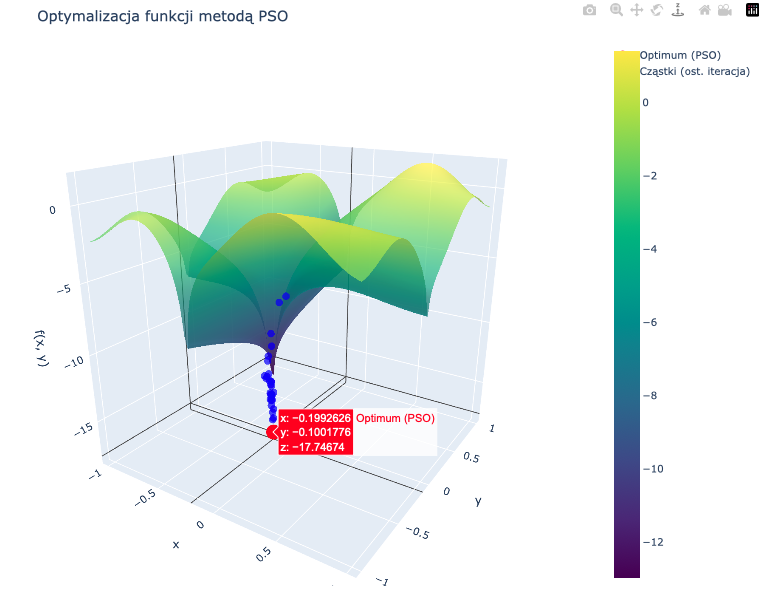

Następnie przystąpiłam do badania wyników działania algorytmu PSO dla różnych zestawów parametrów:

Testowanie różnych kombinacji c1 i c2:


  0%|          | 0/4 [00:00<?, ?it/s]

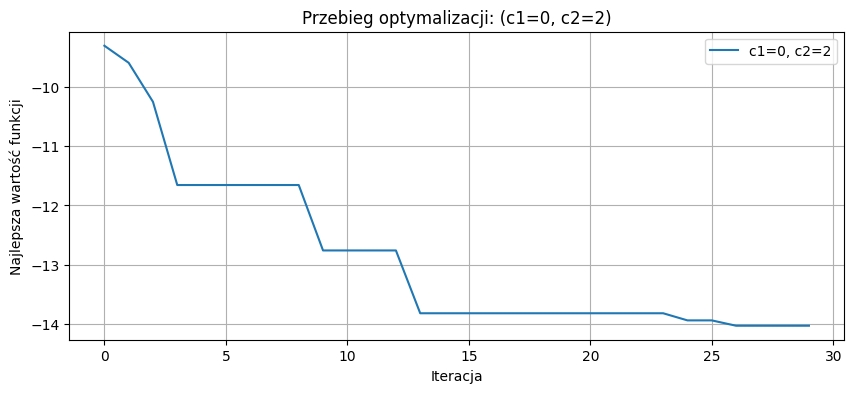

 25%|██▌       | 1/4 [00:00<00:02,  1.35it/s]

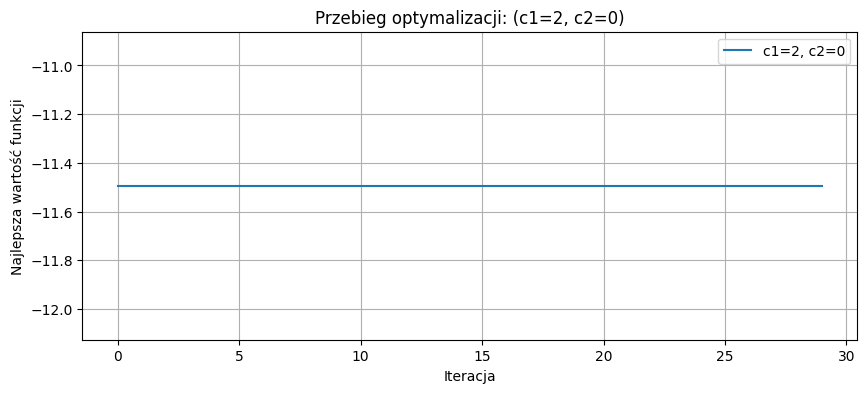

 50%|█████     | 2/4 [00:01<00:01,  1.48it/s]

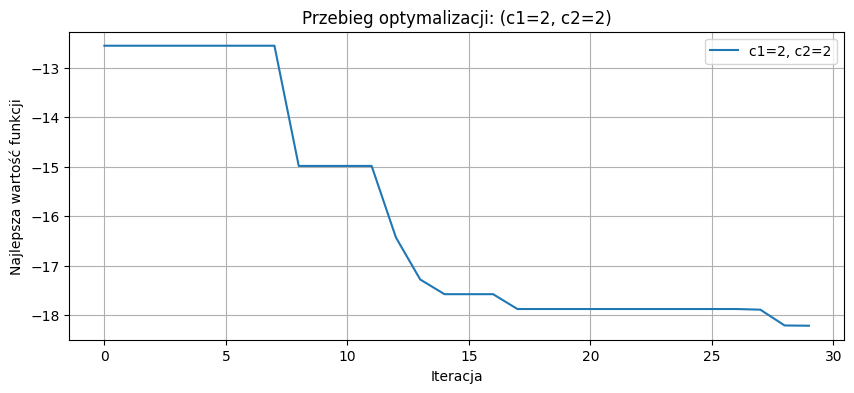

 75%|███████▌  | 3/4 [00:01<00:00,  1.64it/s]

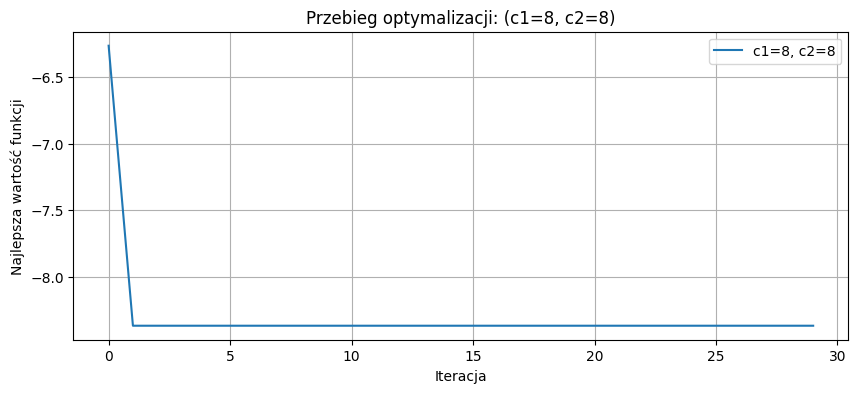

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



Testowanie różnych wartości bezwładności (w):


  0%|          | 0/5 [00:00<?, ?it/s]

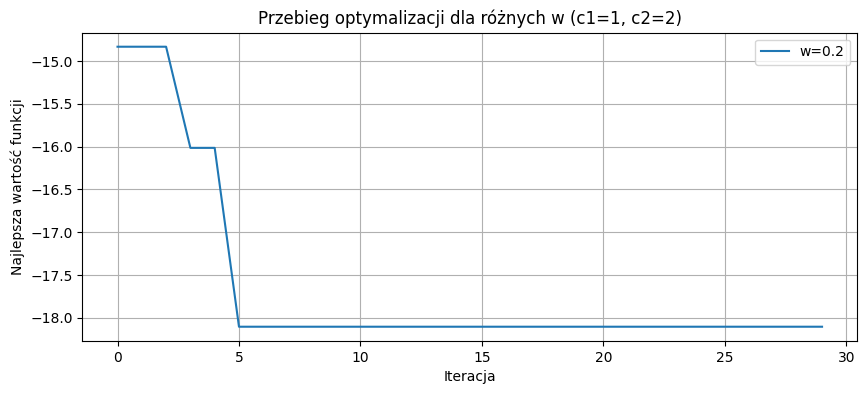

 20%|██        | 1/5 [00:00<00:02,  1.85it/s]

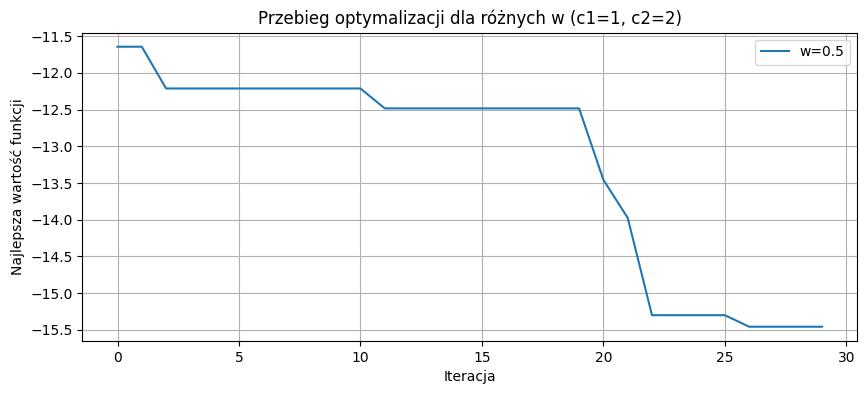

 40%|████      | 2/5 [00:01<00:01,  1.87it/s]

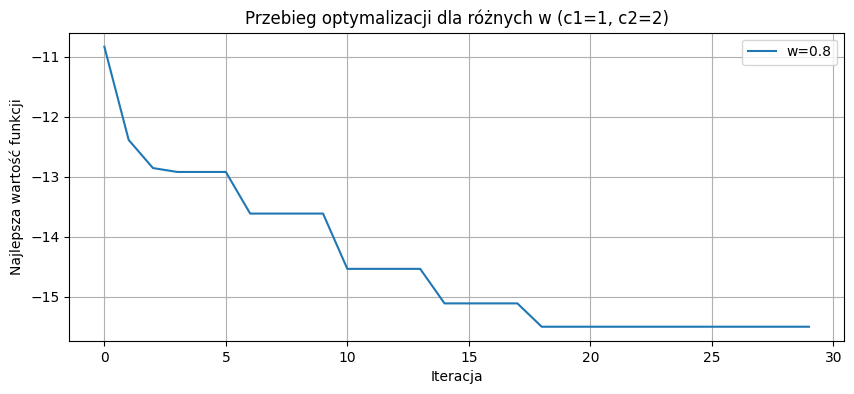

 60%|██████    | 3/5 [00:01<00:01,  1.66it/s]

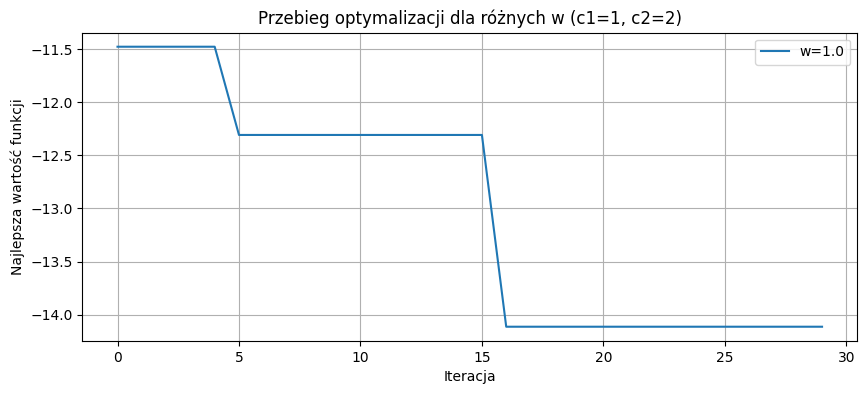

 80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

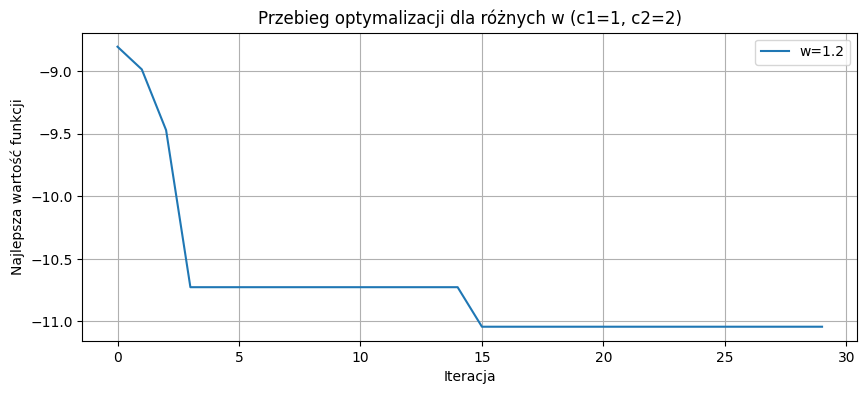

100%|██████████| 5/5 [00:02<00:00,  1.79it/s]



Test                                               Średnia         Odchylenie      Parametry
----------------------------------------------------------------------------------------------------
(c1=0, c2=2)                                       -15.618543 1.716077        c1=0, c2=2, w=0.5
(c1=2, c2=0)                                       -8.363442 1.731492        c1=2, c2=0, w=0.5
(c1=2, c2=2)                                       -16.932441 0.963910        c1=2, c2=2, w=0.5
(c1=8, c2=8)                                       -9.356601 0.758021        c1=8, c2=8, w=0.5
Test dla w=0.2                                     -18.206558 0.815139        c1=1, c2=2, w=0.2
Test dla w=0.5                                     -17.314204 1.089400        c1=1, c2=2, w=0.5
Test dla w=0.8                                     -15.159730 1.420230        c1=1, c2=2, w=0.8
Test dla w=1.0                                     -13.273082 1.588468        c1=1, c2=2, w=1.0
Test dla w=1.2                        

In [ ]:
def test_pso_parameters():
    test_cases = [
        {'c1': 0, 'c2': 2, 'w': 0.5, 'name': '(c1=0, c2=2)'},
        {'c1': 2, 'c2': 0, 'w': 0.5, 'name': '(c1=2, c2=0)'},
        {'c1': 2, 'c2': 2, 'w': 0.5, 'name': '(c1=2, c2=2)'},
        {'c1': 8, 'c2': 8, 'w': 0.5, 'name': '(c1=8, c2=8)'}
    ]
    test_w = [0.2, 0.5, 0.8, 1.0, 1.2]
    results = []

    print("Testowanie różnych kombinacji c1 i c2:")
    for case in tqdm(test_cases):
        fitness_values = []
        best_history = []

        for _ in range(10):
            _, fitness, _, _, bests = pso(fun, c1=case['c1'], c2=case['c2'], w=case['w'])
            fitness_values.append(fitness)
            best_history.append(bests)

        plt.figure(figsize=(10, 4))
        plt.plot(best_history[0], label=f"c1={case['c1']}, c2={case['c2']}")
        plt.title(f"Przebieg optymalizacji: {case['name']}")
        plt.xlabel("Iteracja")
        plt.ylabel("Najlepsza wartość funkcji")
        plt.grid(True)
        plt.legend()
        plt.show()

        results.append({
            'name': case['name'],
            'mean': np.mean(fitness_values),
            'std': np.std(fitness_values),
            'params': f"c1={case['c1']}, c2={case['c2']}, w={case['w']}"
        })

    print("\nTestowanie różnych wartości bezwładności (w):")
    for w in tqdm(test_w):
        fitness_values = []
        best_history = []

        for _ in range(10):
            _, fitness, _, _, bests = pso(fun, c1=1, c2=2, w=w)
            fitness_values.append(fitness)
            best_history.append(bests)

        plt.figure(figsize=(10, 4))
        plt.plot(best_history[0], label=f"w={w}")
        plt.title(f"Przebieg optymalizacji dla różnych w (c1=1, c2=2)")
        plt.xlabel("Iteracja")
        plt.ylabel("Najlepsza wartość funkcji")
        plt.grid(True)
        plt.legend()
        plt.show()

        results.append({
            'name': f"Test dla w={w}",
            'mean': np.mean(fitness_values),
            'std': np.std(fitness_values),
            'params': f"c1=1, c2=2, w={w}"
        })
    print("\n")
    print("Test".ljust(50), "Średnia".ljust(15), "Odchylenie".ljust(15), "Parametry")
    print("-" * 100)

    for res in results:
        print(f"{res['name'][:50].ljust(50)} {res['mean']:.6f}".ljust(15),
              f"{res['std']:.6f}".ljust(15), res['params'])

    best = min(results, key=lambda x: x['mean'])
    print(f"\nNAJLEPSZY WYNIK: {best['name']}")
    print(f"Średnia wartość: {best['mean']:.6f}")
    print(f"Parametry: {best['params']}")

test_pso_parameters()

W pierwszej części eksperymentu, gdy testowano algorytm dla różnych parametrów c, wyraźnie widoczna była przewaga kombinacji (c1=2, c2=2). Wynika to z faktu, że wyższy współczynnik c1 zwiększa tendencję cząstek do eksploracji przestrzeni na podstawie własnych doświadczeń, podczas gdy wyższy c2 wzmacnia dążenie cząstek do podążania za 'liderem' roju. Choć to drugie przyspiesza zbieżność, istnieje ryzyko utknięcia w minimum lokalnym.

Dla celów eksperymentalnych przetestowałam również ekstremalne wartości c1=8 i c2=8. Wynik $(-9.356601 ± 0.758021)$ potwierdził przypuszczenia - algorytm utknął w minimum lokalnym, co nie jest pożądanym efektem. Potwierdza to konieczność doboru współczynników c1 i c2 o umiarkowanych wartościach.

W przypadku innych testowanych kombinacji wyniki były zbliżone do oczekiwań, jednak zauważalne były pewne prawidłowości. Gdy przeważał składnik społeczny (c2), obserwowano problem ograniczonej eksploracji - wszystkie cząstki zachowywały się jak jedna zwarta grupa podążająca za liderem, co na wykresie objawiało się prostą linią. Z kolei przy przewadze składnika indywidualnego (c1) cząstki kierowały się swoimi najlepszymi pozycjami, co wprawdzie sprzyjało eksploracji, ale utrudniało zbieżność do wspólnego rozwiązania. W tym przypadku algorytm stopniowo osiągał minimum lokalne, ale działało to wolniej ze względu na wiele niezależnych optymalizatorów.
Zatem najlepsze rezultaty dawała kombinacja z c1>0 i c2=0, niż z c1=0 i c2>0.

W ogólnym przypadku należy dążyć do sytuacji, gdzie oba współczynniki są dodatnie (c1>0 i c2>0), ale o umiarkowanych wartościach. Zbyt wysokie wartości mogą prowadzić do niepożądanych efektów.

W drugiej części eksperymentu badano wpływ parametru w (współczynnika inercji) na działanie algorytmu. Najlepsze wyniki osiągnięto dla najmniejszej testowanej wartości w=0.2. Taka wartość sprzyja umiarkowanej eksploracji przestrzeni rozwiązań. Wyższe wartości początkowe pogarszały wyniki, prawdopodobnie dlatego, że cząstki nie nadążały z przeszukiwaniem obiecujących obszarów. Optymalny wybór to wartości z zakresu 0.2-0.5. Najlepszą praktyką będzie stopniowe zmniejszanie wartości.'w' w trakcie działania algorytmu, np. liniowo lub w sposób adaptacyjny.



# Zadanie 2

W zadaniu 2 uzyskany najlepszy wynik w miarę możliwości należało porównać z algorytmem genetycznym – dedykowanym dla optymalizacji tej samej funkcji. Zakładamy użycie takiej samej liczby epok dla obu algorytmów. Należało również porównać czas działania obydwu algorytmów.

W rozwiązaniu użyłam wersji PSO, w której parametry wejściowe ustawiono na:
w = 0.2, c1 = 1, c2 = 2.
Algorytm dla tych wartości nie wykazuje znaczących różnic w porównaniu do wersji testowanej wcześniej.

Dodatkowo zaimplementowałam algorytm genetyczny (GA).
Algorytm zaczyna od losowej inicjalizacji populacji rozwiązań. Następnie w każdej iteracji wybiera najlepsze osobniki, krzyżuje je ze sobą i wprowadza losowe mutacje. Nowa populacja powstaje przez wybranie najlepszych rozwiązań spośród rodziców i potomstwa. Proces powtarza się, stale śledząc najlepsze osiągnięte rozwiązanie, aż do spełnienia warunków stopu.

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

def fun(p):
    x, y = p
    return (2 * np.log(np.abs(x + 0.2) + 0.002) +
            np.log(np.abs(y + 0.1) + 0.001) +
            np.cos(3 * x) + 2 * np.sin(3 * x * y)**2 +
            np.sin(y)**2 - x**2 - 0.5 * y**2)

def pso(cost_func, dim=2, num_particles=30, max_iter=30, w=0.2, c1=1, c2=2, bounds=(-1, 1)):
    particles = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    avgs = []
    bests_fitness = []

    for _ in range(max_iter):
        r1 = np.random.rand(num_particles, dim)
        r2 = np.random.rand(num_particles, dim)
        velocities = (
            w * velocities
            + c1 * r1 * (best_positions - particles)
            + c2 * r2 * (swarm_best_position - particles)
        )
        particles += velocities
        particles = np.clip(particles, bounds[0], bounds[1])
        fitness_values = np.array([cost_func(p) for p in particles])
        improved = fitness_values < best_fitness
        best_positions[improved] = particles[improved]
        best_fitness[improved] = fitness_values[improved]

        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)

        avgs.append(np.mean(fitness_values))
        bests_fitness.append(swarm_best_fitness)

    return swarm_best_position, swarm_best_fitness, avgs, bests_fitness

def genetic_algorithm(cost_func, dim=2, pop_size=30, max_iter=30, mutation_rate=0.1, bounds=(-1, 1)):
    population = np.random.uniform(bounds[0], bounds[1], (pop_size, dim))
    fitness_values = np.array([cost_func(ind) for ind in population])

    best_index = np.argmin(fitness_values)
    best_solution = population[best_index]
    best_fitness = fitness_values[best_index]

    avgs = []
    bests_fitness = []

    for _ in range(max_iter):
        parents_indices = np.random.choice(pop_size, size=(pop_size // 2, 2), replace=True)
        offspring = np.array([population[np.argmin(fitness_values[parent_pair])] for parent_pair in parents_indices])

        crossover_points = np.random.randint(0, dim, size=(pop_size // 2,))
        for i, cp in enumerate(crossover_points):
            offspring[i, cp:] = population[np.random.randint(pop_size), cp:]

        mutations = np.random.uniform(bounds[0], bounds[1], offspring.shape) * mutation_rate
        offspring += mutations
        offspring = np.clip(offspring, bounds[0], bounds[1])

        offspring_fitness = np.array([cost_func(ind) for ind in offspring])
        population = np.vstack([population, offspring])
        fitness_values = np.concatenate([fitness_values, offspring_fitness])

        best_indices = np.argsort(fitness_values)[:pop_size]
        population = population[best_indices]
        fitness_values = fitness_values[best_indices]

        best_index = np.argmin(fitness_values)
        best_solution = population[best_index]
        best_fitness = fitness_values[best_index]

        avgs.append(np.mean(fitness_values))
        bests_fitness.append(best_fitness)

    return best_solution, best_fitness, avgs, bests_fitness

In [ ]:
pso_times = []
ga_times = []
pso_scores = []
ga_scores = []

print("PSO/GA")
for i in range(10):
    print(f"\nTest {i + 1}")
    start_pso = time.time()
    sol_pso, fit_pso, _, _ = pso(fun, c1=1, c2=2, w=0.2)
    time_pso = time.time() - start_pso

    start_ga = time.time()
    sol_ga, fit_ga, _, _ = genetic_algorithm(fun)
    time_ga = time.time() - start_ga

    print(f"PSO: Fitness = {fit_pso:.6f}, Czas = {time_pso:.4f}s")
    print(f"GA : Fitness = {fit_ga:.6f}, Czas = {time_ga:.4f}s")

    pso_times.append(time_pso)
    ga_times.append(time_ga)
    pso_scores.append(fit_pso)
    ga_scores.append(fit_ga)

print(f"Średni czas PSO: {np.mean(pso_times):.4f}s")
print(f"Średni czas GA : {np.mean(ga_times):.4f}s")
print(f"Średni fitness PSO: {np.mean(pso_scores):.6f}")
print(f"Średni fitness GA : {np.mean(ga_scores):.6f}")

PSO/GA

Test 1
PSO: Fitness = -18.526669, Czas = 0.0416s
GA : Fitness = -17.125175, Czas = 0.0535s

Test 2
PSO: Fitness = -18.535303, Czas = 0.0411s
GA : Fitness = -16.052982, Czas = 0.0467s

Test 3
PSO: Fitness = -12.677314, Czas = 0.0306s
GA : Fitness = -15.929879, Czas = 0.0235s

Test 4
PSO: Fitness = -18.490466, Czas = 0.0214s
GA : Fitness = -14.996132, Czas = 0.0244s

Test 5
PSO: Fitness = -18.537844, Czas = 0.0286s
GA : Fitness = -14.754071, Czas = 0.0457s

Test 6
PSO: Fitness = -8.350143, Czas = 0.0437s
GA : Fitness = -14.729941, Czas = 0.0534s

Test 7
PSO: Fitness = -18.535447, Czas = 0.0246s
GA : Fitness = -15.375811, Czas = 0.0233s

Test 8
PSO: Fitness = -14.481747, Czas = 0.0448s
GA : Fitness = -15.594051, Czas = 0.0260s

Test 9
PSO: Fitness = -18.320749, Czas = 0.0230s
GA : Fitness = -16.655026, Czas = 0.0244s

Test 10
PSO: Fitness = -18.533101, Czas = 0.0399s
GA : Fitness = -15.287234, Czas = 0.0597s
Średni czas PSO: 0.0339s
Średni czas GA : 0.0381s
Średni fitness PSO: -16

Na podstawie uzyskanych wyników można stwierdzić, że algorytm PSO wykazał się wyższą skutecznością niż algorytm genetyczny (GA) dla rozpatrywanej funkcji celu. Średnia wartość funkcji fitness osiągnięta przez PSO była lepsza (-18.533 vs -15.287), przy porównywalnych czasach wykonania obu metod (z niewielką przewagą PSO).

PSO charakteryzuje się szybszą zbieżnością i większą stabilnością w odnajdywaniu wartości bliskich optimum globalnemu. Wynika to z mechanizmu aktualizacji pozycji cząstek, który uwzględnia zarówno najlepsze lokalne, jak i globalne wyniki. GA, jako metoda ewolucyjna, jest bardziej podatna na utknięcie w minimum lokalnym i często wymaga większej liczby iteracji oraz bardziej złożonego strojenia parametrów(prawdopodobieństwa, krzyżowania, mutacji).

PSO lepiej radzi sobie w przestrzeniach ciągłych, gdzie zmienne mogą przyjmować dowolne wartości. GA, ze względu na swoją strukturę dyskretną i losowe operacje genetyczne, gorzej radzi sobie w przypadku skomplikowanych przestrzeni poszukiwań.

# Bibliografia

1. https://www.researchgate.net/publication/322164684_Metody_roju_czastek_w_optymalizacji_procesow_transportowych_i_logistycznych_Particle_swarm_methods_in_optimization_of_transport_and_logistic_processes

2. https://www.researchgate.net/post/Can-you-please-list-main-advantages-of-PSO-over-GA

3. https://www.rose-hulman.edu/class/cs/csse453/archive/2011-12/presentations/PSOvsGA.pdf